**Описание проекта**

Поступил заказ из каршеринговой компании: нужно создать систему, которая могла бы оценить риск ДТП по выбранному маршруту движения. Под риском понимается вероятность ДТП с любым повреждением транспортного средства, кроме царапин. Как только водитель забронировал автомобиль, сел за руль и выбрал маршрут, система должна оценить уровень риска. Если уровень риска высок, водитель увидит предупреждение и рекомендации по маршруту.


**Краткое описание таблиц с данными**
- collisions — общая информация о ДТП
Имеет уникальный case_id. Эта таблица описывает общую информацию о ДТП. Например, где оно произошло и когда.

- parties — информация об участниках ДТП
Имеет неуникальный case_id, который сопоставляется с соответствующим ДТП в таблице collisions. Каждая строка здесь описывает одну из сторон, участвующих в ДТП. Если столкнулись две машины, в этой таблице должно быть две строки с совпадением case_id. Если нужен уникальный идентификатор, это case_id and party_number.

- vehicles — информация о пострадавших машинах
Имеет неуникальные case_id и неуникальные party_number, которые сопоставляются с таблицей collisions и таблицей parties. Если нужен уникальный идентификатор, это case_id and party_number.

## Подключитесь к базе. Загрузите таблицы sql

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sqlalchemy import create_engine 
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import OrdinalEncoder
from sklearn.metrics import f1_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from catboost import CatBoostClassifier
import catboost
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold
from catboost import Pool
## Загружаем библиотеки

Конфигурация для подключения к базе данных.

In [2]:
db_config = {
'user': 'praktikum_student', # имя пользователя,
'pwd': 'Sdf4$2;d-d30pp', # пароль,
'host': 'rc1b-wcoijxj3yxfsf3fs.mdb.yandexcloud.net',
'port': 6432, # порт подключения,
'db': 'data-science-vehicle-db' # название базы данных,
}

connection_string = 'postgresql://{}:{}@{}:{}/{}'.format(
    db_config['user'],
    db_config['pwd'],
    db_config['host'],
    db_config['port'],
    db_config['db'],
)

Теперь создадим подключение.

In [3]:
engine = create_engine(connection_string) 

Проверим наличие таблиц, через запрос к базе данных.

In [4]:
query = '''
SELECT table_name
FROM information_schema.tables
WHERE table_schema='public';
'''
df_tables = pd.read_sql_query(query, con=engine) 

df_tables

,table_name
0,case_ids
1,collisions
2,parties
3,vehicles


**Вывод** 


Подключение создано. Убедились в наличие таблиц представленных в описании и на ER диаграмме. 

## Проведите первичное исследование таблиц

Загрузим поочерёдно имеющиеся у нас таблицы.

In [5]:
query = '''
SELECT *
FROM case_ids
LIMIT 5;
'''

df_case_ids = pd.read_sql_query(query, con=engine) 

In [6]:
df_case_ids.head(5)

,case_id,db_year
0,0081715,2021
1,0726202,2021
2,3858022,2021
3,3899441,2021
4,3899442,2021


Загрузили таблицу "case_ids". Здесь мы видим уникальный номер зарегистрированного происшествия и год, когда оно зарегистрировано.

In [7]:
query = '''
SELECT *
FROM collisions
LIMIT 5;
'''

df_collisions = pd.read_sql_query(query, con=engine)

In [8]:
df_collisions.head(5)

,case_id,county_city_location,county_location,distance,direction,intersection,weather_1,location_type,collision_damage,party_count,primary_collision_factor,pcf_violation_category,type_of_collision,motor_vehicle_involved_with,road_surface,road_condition_1,lighting,control_device,collision_date,collision_time
0,4083072,1942,los angeles,528.0,north,0,cloudy,highway,small damage,2,vehicle code violation,unsafe lane change,sideswipe,other motor vehicle,wet,normal,daylight,none,2009-01-22,07:25:00
1,4083075,4313,santa clara,0.0,None,1,clear,None,small damage,1,vehicle code violation,improper passing,hit object,fixed object,dry,normal,dark with street lights,functioning,2009-01-03,02:26:00
2,4083073,0109,alameda,0.0,None,1,clear,None,scratch,2,vehicle code violation,improper turning,broadside,other motor vehicle,dry,normal,dark with street lights,functioning,2009-01-11,03:32:00
3,4083077,0109,alameda,0.0,None,1,clear,None,scratch,2,vehicle code violation,automobile right of way,broadside,other motor vehicle,dry,normal,daylight,functioning,2009-01-11,10:35:00
4,4083087,4313,santa clara,0.0,None,1,clear,None,scratch,2,vehicle code violation,speeding,rear end,other motor vehicle,dry,None,dark with street lights,functioning,2009-01-02,22:43:00


Загрузили таблицу "collisions". В этой таблице представлены данные о происшествии.

In [9]:
query = '''
SELECT *
FROM parties
LIMIT 5;
'''

df_parties = pd.read_sql_query(query, con=engine)

In [10]:
df_parties.head(5)

,id,case_id,party_number,party_type,at_fault,insurance_premium,party_sobriety,party_drug_physical,cellphone_in_use
0,22,3899454,1,road signs,1,29.0,had not been drinking,None,0
1,23,3899454,2,road signs,0,7.0,had not been drinking,None,0
2,29,3899462,2,car,0,21.0,had not been drinking,None,0
3,31,3899465,2,road signs,0,24.0,had not been drinking,None,0
4,41,3899478,2,road bumper,0,NaN,not applicable,not applicable,0


Таблица "parties" предоставляет нам данные об участниках происшествия.

In [11]:
query = '''
SELECT *
FROM vehicles
LIMIT 5;
'''

df_vehicles = pd.read_sql_query(query, con=engine)

In [12]:
df_vehicles.head(5)

,id,case_id,party_number,vehicle_type,vehicle_transmission,vehicle_age
0,1175713,5305032,2,sedan,manual,3
1,1,3858022,1,sedan,auto,3
2,1175712,5305030,1,sedan,auto,3
3,1175717,5305033,3,sedan,auto,5
4,1175722,5305034,2,sedan,auto,5


В таблице "vehicles" представлены данные об автомобиле.

### Выводы

- Все таблицы с данными загрузились корректно. 
- Таблица "case_ids" не соответствует ER - диаграмме, остальные таблицы этой диаграмме соотвествуют.
- Отсутствует описание данных некоторых столбцов.
- Внешним ключом является столбец "case_id" (id происшествия).

В целом данные загружены и могут быть использованы для дальнейшего анализа.

##  Проведите статистический анализ факторов ДТП

###  Cоздание аналитических задач для рабочей группа

#### Проанализировать в какие месяцы происходило больше всего аварий

**Описание задачи**

Провести анализ количества ДТП в каждый из месяцев, результат представить в виде таблицы и диаграммы.

**Порядок выполнения**

В таблице "collisions" сгруппировать данные по месяцам и подсчитать количество происшествий, отсортировать количество происшествий по убыванию. Вывесть таблицу и гистограмму.

In [13]:
query = '''
SELECT COUNT(case_id) as count_case,
       to_char(collision_date, 'Month') as month 
       
FROM collisions
GROUP BY month
ORDER BY count_case desc;
'''

df_mounth = pd.read_sql_query(query, con=engine)

In [14]:
df_mounth

,count_case,month
0,139581,March
1,132044,January
2,130316,May
3,130180,April
4,128858,February
5,112237,October
6,107945,December
7,105159,September
8,104770,November
9,104089,August


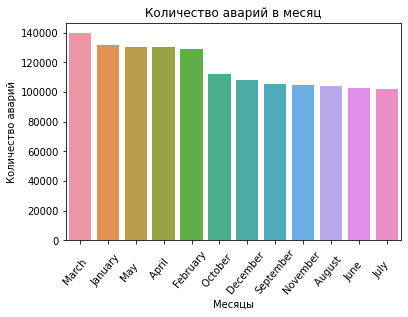

<Figure size 1080x576 with 0 Axes>

In [15]:
sns.barplot(data = df_mounth, x='month', y='count_case')
plt.title('Количество аварий в месяц')
plt.xticks(rotation=50)
plt.xlabel('Месяцы')
plt.ylabel('Количество аварий')
plt.figure(figsize=(15, 8))
plt.show()

**Количество ДТП с распределением по месяцам для каждого отдельного года.**

In [16]:
query = '''
SELECT COUNT(case_id) as count_case,
       EXTRACT(YEAR FROM collision_date) as year,
       to_char(collision_date, 'Month') as month
FROM collisions
GROUP BY month, year
ORDER BY year, count_case desc;
   
'''

df_mounths_by_year = pd.read_sql_query(query, con=engine)

In [17]:
df_mounths_by_year

,count_case,year,month
0,37835,2009.0,October
1,36916,2009.0,May
2,36648,2009.0,March
3,36060,2009.0,December
4,35555,2009.0,September
5,35239,2009.0,April
6,35161,2009.0,July
7,35062,2009.0,January
8,34562,2009.0,November
9,34508,2009.0,August


Выведем отдельно статистику по 2012 году.

In [18]:
query = '''
SELECT COUNT(case_id) as count_case,
       to_char(collision_date, 'Month') as month
FROM collisions

GROUP BY month, EXTRACT(YEAR FROM collision_date)

HAVING EXTRACT(YEAR FROM collision_date) = 2012 
ORDER BY count_case desc;
   
'''

df_mounths_2012 = pd.read_sql_query(query, con=engine)

In [19]:
df_mounths_2012

,count_case,month
0,32498,March
1,32020,January
2,30377,February
3,29143,April
4,25168,May
5,3062,June
6,622,August
7,510,September
8,390,July
9,304,October


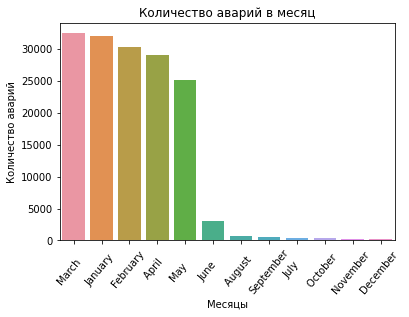

<Figure size 1080x576 with 0 Axes>

In [20]:
sns.barplot(data = df_mounths_2012, x='month', y='count_case')
plt.title('Количество аварий в месяц')
plt.xticks(rotation=50)
plt.xlabel('Месяцы')
plt.ylabel('Количество аварий')
plt.figure(figsize=(15, 8))
plt.show()

**Вывод** 

Есть основания считать, что в некоторые годы у нас не полные данные. Следовательно этот показатель нельзя использовать при дальнейшем построении моделей.

#### Провеcти анализ серьёзности повреждений транспортного средства, исходя из состояния дороги в момент ДТП 

**Описание задачи**

Провести анализ серьёзности происшествия исходя из состояния дороги в момент ДТП.

**Порядок выполнения**

1) Посмотреть общее распределение серьёзности повреждений.
В таблице "collisions" сгруппировать данные столбцу "collision_damage" и посчитать количество происшествий. Вывесть таблицу и круговую диаграмму.

2) Посмотреть как распределяются происшествия в зависимости от состояния дороги.
В таблице "collisions" сгруппировать данные столбцу "road_surface" и посчитать количество происшествий. Вывесть таблицу и круговую диаграмму.

3) Посмотреть распределение серьёзности повреждений при сухом и влажном состоянии дороги.
В таблице "collisions" сгруппировать данные столбцу "collision_damage" с условиями: road_surface = 'dry' и road_surface = 'wet' соответственно. Посчитать количество происшествий. Вывесть таблицу и круговую диаграмму. 

Сначала посмотрим общее рапределение по серьёзности повреждений.

In [21]:
query = '''
SELECT collision_damage,
       COUNT(case_id) as count_case
FROM collisions
GROUP BY collision_damage;
'''

df_collision_damage = pd.read_sql_query(query, con=engine)

In [22]:
df_collision_damage

,collision_damage,count_case
0,fatal,10793
1,middle damage,166583
2,scratch,346106
3,severe damage,30747
4,small damage,845771


Для наглядности построим круговую диаграмму.

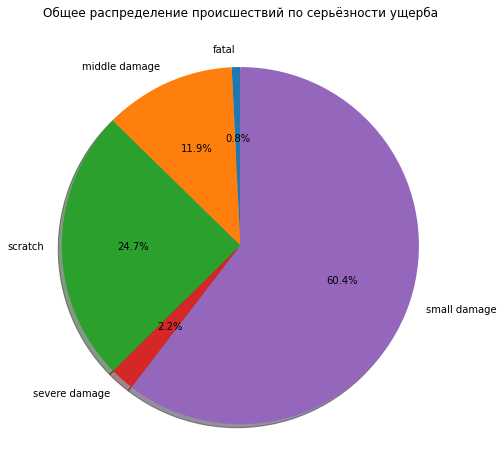

In [23]:
labels = df_collision_damage['collision_damage']
sizes = df_collision_damage['count_case']

fig1, ax1 = plt.subplots(figsize=(8, 9))
ax1.pie(sizes, labels=labels, autopct='%1.1f%%',
        shadow=True, startangle=90)
ax1.set_title("Общее распределение происшествий по серьёзности ущерба")

plt.show()

Как мы видим больше всего происшествий 60,4% с небольшими повреждениями, при этом происшествия с фатальными повреждениями происходят менее чем в 1% случаев.

Теперь посмотрим как распределяются происшествия в зависимости от состояния дороги.

In [24]:
query = '''
SELECT road_surface,
       COUNT(case_id) as count_case
FROM collisions
GROUP BY road_surface;
'''

df_road_surface = pd.read_sql_query(query, con=engine)

In [25]:
df_road_surface

,road_surface,count_case
0,dry,1242026
1,slippery,1384
2,snowy,7261
3,wet,136236
4,None,13093


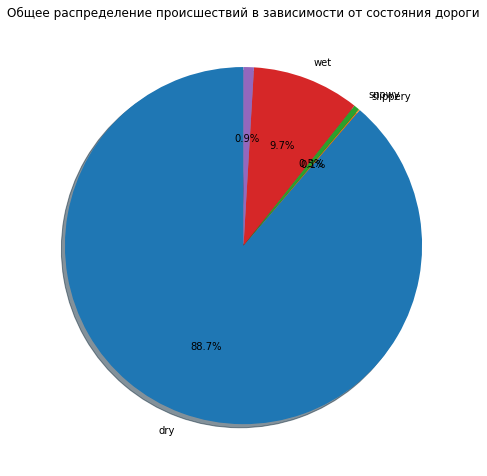

In [26]:
labels = df_road_surface['road_surface']
sizes = df_road_surface['count_case']

fig1, ax1 = plt.subplots(figsize=(8, 9))
ax1.pie(sizes, labels=labels, autopct='%1.1f%%',
        shadow=True, startangle=90)
ax1.set_title("Общее распределение происшествий в зависимости от состояния дороги")

plt.show()

Большая часть происшествий происходит при сухом покрытии 88,7%; однако значимую долю составляют происшествия при мокром покрытии: 9,7%.

Теперь посмотрим как распределяются происшествия по серьёзности последствий при сухом и влажном покрытии.

In [27]:
query = '''
SELECT collision_damage,
       COUNT(case_id) as count_case
FROM collisions
WHERE road_surface = 'dry' 
GROUP BY collision_damage;
'''

df_collision_damage_dry = pd.read_sql_query(query, con=engine)

In [28]:
df_collision_damage_dry 

,collision_damage,count_case
0,fatal,9823
1,middle damage,151015
2,scratch,307963
3,severe damage,27827
4,small damage,745398


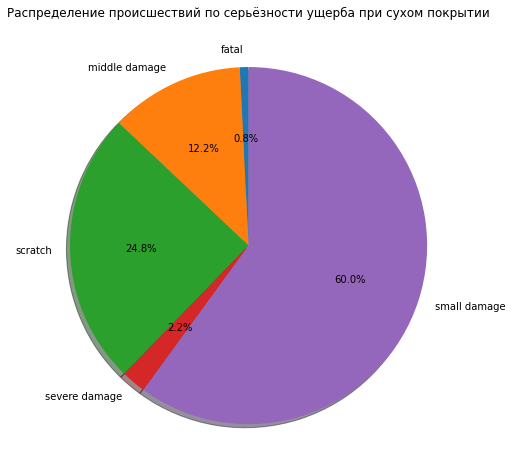

In [29]:
labels = df_collision_damage_dry['collision_damage']
sizes = df_collision_damage_dry['count_case']

fig1, ax1 = plt.subplots(figsize=(8, 9))
ax1.pie(sizes, labels=labels, autopct='%1.1f%%',
        shadow=True, startangle=90)
ax1.set_title("Распределение происшествий по серьёзности ущерба при сухом покрытии")

plt.show()

In [30]:
query = '''
SELECT collision_damage,
       COUNT(case_id) as count_case
FROM collisions
WHERE road_surface = 'wet' 
GROUP BY collision_damage;
'''

df_collision_damage_wet = pd.read_sql_query(query, con=engine)

In [31]:
df_collision_damage_wet

,collision_damage,count_case
0,fatal,857
1,middle damage,13190
2,scratch,33301
3,severe damage,2470
4,small damage,86418


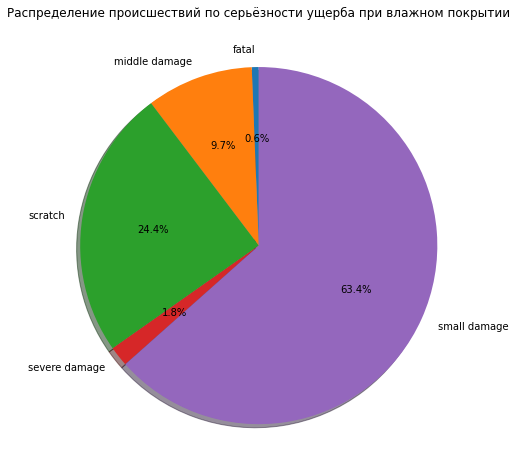

In [32]:
labels = df_collision_damage_wet['collision_damage']
sizes = df_collision_damage_wet['count_case']

fig1, ax1 = plt.subplots(figsize=(8, 9))
ax1.pie(sizes, labels=labels, autopct='%1.1f%%',
        shadow=True, startangle=90)
ax1.set_title("Распределение происшествий по серьёзности ущерба при влажном покрытии")

plt.show()

**Вывод** Как мы увидели из диаграмм вышы и при сухом и при влажном покрытии примерно 60% происшествий происходят с небольшим ущербом, около четверти происшествий обходятся "царапинами".

#### Найдйдём самые частые причины ДТП 

**Описание задачи**

Найти самые частые причины ДТП.

**Порядок выполнения**

В таблице "collisions" сгруппировать данные по столбцу "primary_collision_factor" и подсчитать количество происшествий, отсортировать количество происшествий по убыванию. Вывесть таблицу и гистограмму.

In [33]:
query = '''
SELECT primary_collision_factor,
       COUNT(case_id) as count_case
FROM collisions
GROUP BY primary_collision_factor 
ORDER BY count_case desc;
'''

df_primary_collision_factor = pd.read_sql_query(query, con=engine)

In [34]:
df_primary_collision_factor

,primary_collision_factor,count_case
0,vehicle code violation,1316453
1,unknown,37014
2,other than driver,29780
3,other improper driving,8470
4,None,8166
5,fell asleep,117


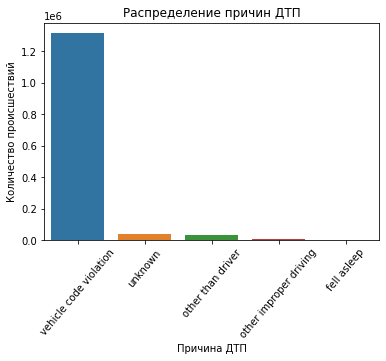

<Figure size 1080x576 with 0 Axes>

In [35]:
sns.barplot(data = df_primary_collision_factor, x='primary_collision_factor', y='count_case')
plt.title('Распределение причин ДТП')
plt.xticks(rotation=50)
plt.xlabel('Причина ДТП')
plt.ylabel('Количество происшествий')
plt.figure(figsize=(15, 8))
plt.show()

**Вывод** В подавляющем большинстве случаев причиной ДТП стали нарушения правил ПДД.

#### Среди тех происшествий которые произошли по причине нарушения ПДД найти самые распространённые нарушения 

**Описание задачи**

Найти самые распространённые нарушения ПДД среди тех происшествий, причиной которых стало нарушение правил дорожного движения.

**Порядок выполнения**

В таблице "collisions" сгруппировать данные по столбцу "pcf_violation_category" и подсчитать количество происшествий с условием primary_collision_factor = 'vehicle code violation', отсортировать количество происшествий по убыванию. Вывесть таблицу и гистограмму.

In [36]:
query = '''
SELECT pcf_violation_category,
       COUNT(case_id) as count_case
FROM collisions
WHERE primary_collision_factor = 'vehicle code violation' 
GROUP BY pcf_violation_category 
ORDER BY count_case desc;
'''

df_pcf_violation_category = pd.read_sql_query(query, con=engine)

In [37]:
df_pcf_violation_category

,pcf_violation_category,count_case
0,speeding,438439
1,improper turning,238987
2,automobile right of way,158291
3,dui,110476
4,unsafe lane change,93962
5,traffic signals and signs,72751
6,unsafe starting or backing,55674
7,wrong side of road,33631
8,following too closely,30033
9,None,19788


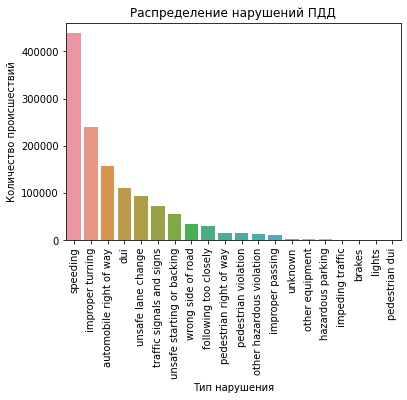

<Figure size 1080x576 with 0 Axes>

In [38]:
sns.barplot(data = df_pcf_violation_category, x='pcf_violation_category', y='count_case')
plt.title('Распределение нарушений ПДД')
plt.xticks(rotation=90)
plt.xlabel('Тип нарушения')
plt.ylabel('Количество происшествий')
plt.figure(figsize=(15, 8))
plt.show()

**Вывод** В тройку лидеров у нас попали скоростной режим, неправильный поворот и приоритетное право проезда.

#### Провести анализ количества происшествий в зависимости от освещения с участниками типа "Car".

**Описание задачи**

Для участников типа "Car" провести анализ количества происшествий в зависимости от освещения.

**Порядок выполнения**

Объеденить таблицы "collisions" и "parties". Cгруппировать данные по столбцу "lighting", таблицы "collisions" и сделать "срез" по условию party_type = 'car' из таблицы "parties". Подсчитать количество происшествий, отсортировать количество происшествий по убыванию. Вывесть таблицу и гистограмму.

In [39]:
query = '''
SELECT co.lighting,
       COUNT(co.case_id) as count_case
FROM collisions as co
INNER JOIN parties pa ON co.case_id = pa.case_id
WHERE pa.party_type = 'car' 
GROUP BY lighting 
ORDER BY count_case desc;
'''

df_lighting = pd.read_sql_query(query, con=engine)

In [40]:
df_lighting

,lighting,count_case
0,daylight,1751526
1,dark with street lights,460171
2,dark with no street lights,155827
3,dusk or dawn,81385
4,None,13698
5,dark with street lights not functioning,6707


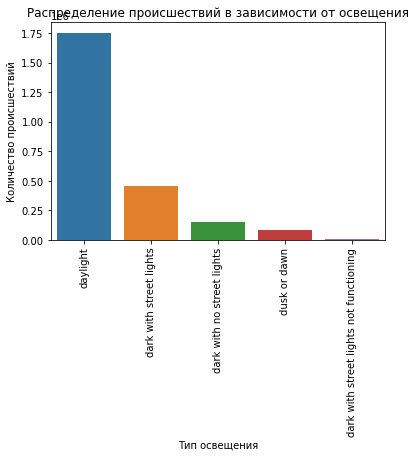

<Figure size 1080x576 with 0 Axes>

In [41]:
sns.barplot(data = df_lighting, x='lighting', y='count_case')
plt.title('Распределение происшествий в зависимости от освещения')
plt.xticks(rotation=90)
plt.xlabel('Тип освещения')
plt.ylabel('Количество происшествий')
plt.figure(figsize=(15, 8))
plt.show()

**Вывод**

Большая часть происшествий произошла в светлое время суток.


#### Провести анализ количества происшествий в зависимости от типа дороги для участников  типа "Car".

**Описание задачи**

Для участников типа "Car" провести анализ количества происшествий в зависимости от типа дороги.

**Порядок выполнения**

Объеденить таблицы "collisions" и "parties". Cгруппировать данные по столбцу "location_type", таблицы "collisions" и сделать "срез" по условию party_type = 'car' из таблицы "parties". Подсчитать количество происшествий, отсортировать количество происшествий по убыванию. Вывесть таблицу и гистограмму.

In [42]:
query = '''
SELECT co.location_type,
       COUNT(co.case_id) as count_case
FROM collisions as co
INNER JOIN parties pa ON co.case_id = pa.case_id
WHERE pa.party_type = 'car' 
GROUP BY location_type 
ORDER BY count_case desc;
'''

df_location_type = pd.read_sql_query(query, con=engine)

In [43]:
df_location_type

,location_type,count_case
0,None,1462555
1,highway,822271
2,ramp,134145
3,intersection,50343


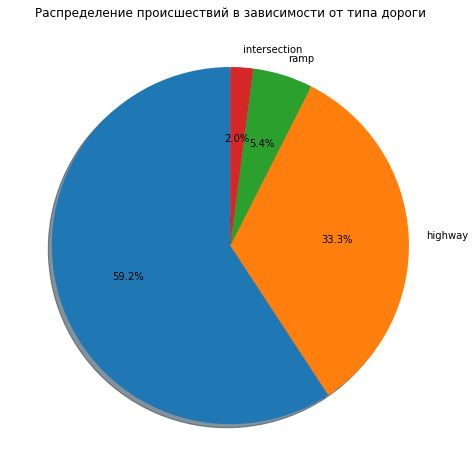

In [44]:
labels = df_location_type['location_type']
sizes = df_location_type['count_case']

fig1, ax1 = plt.subplots(figsize=(8, 9))
ax1.pie(sizes, labels=labels, autopct='%1.1f%%',
        shadow=True, startangle=90)
ax1.set_title("Распределение происшествий в зависимости от типа дороги")

plt.show()

**Вывод**

В большинстве случаев тип дороги не указан. Этот фактор нельзя будет использовать в дальнейшем при построении модели.

#### Провести анализ количества происшествий в зависимости от физического состояния участника с участниками типа "Car".

**Описание задачи**

Для участников типа "Car" провести анализ количества происшествий в зависимости от физического состояния участника.

**Порядок выполнения**

Объеденить таблицы "collisions" и "parties". Cгруппировать данные по столбцу "party_drug_physical", таблицы "party_type" и сделать "срез" по условию party_type = 'car' из таблицы "parties". Подсчитать количество происшествий, отсортировать количество происшествий по убыванию. Вывесть таблицу и гистограмму.

In [45]:
query = '''
SELECT pa.party_drug_physical,
       COUNT(co.case_id) as count_case
FROM collisions as co
INNER JOIN parties pa ON co.case_id = pa.case_id
WHERE pa.party_type = 'car' 
GROUP BY pa.party_drug_physical 
ORDER BY count_case desc;
'''

df_party_drug_physical = pd.read_sql_query(query, con=engine)

In [46]:
df_party_drug_physical

,party_drug_physical,count_case
0,None,2191243
1,G,225085
2,not applicable,24024
3,sleepy/fatigued,12542
4,under drug influence,12361
5,impairment - physical,4059


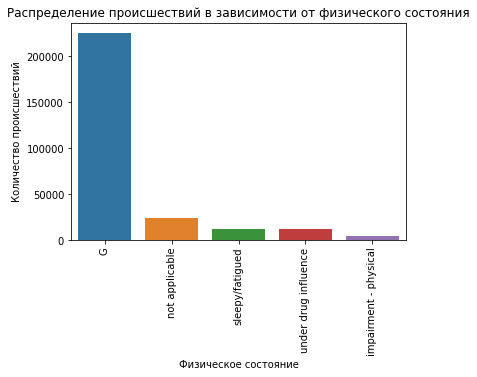

<Figure size 1080x576 with 0 Axes>

In [47]:
sns.barplot(data = df_party_drug_physical, x='party_drug_physical', y='count_case')
plt.title('Распределение происшествий в зависимости от физического состояния')
plt.xticks(rotation=90)
plt.xlabel('Физическое состояние')
plt.ylabel('Количество происшествий')
plt.figure(figsize=(15, 8))
plt.show()

**Вывод** 

В подавляющем большинстве случаев состояние либо не указано, либо не известно, либо не оценивалось. Данный фактор нельзя использовать для дальнейшего построения модели.

## Создайте модель для оценки водительского риска

###  Отбор данных для построение модели

In [48]:
query = '''
WITH 
  p as(
        SELECT distinct case_id,
               at_fault,
               party_type, 
               party_sobriety,
               party_drug_physical,
               cellphone_in_use
        FROM parties),
  c as (
        SELECT distinct case_id,
               weather_1,
               road_surface,
               lighting,
               road_condition_1,
               collision_date,
               collision_damage,
               intersection,
               control_device
        FROM collisions),
  v as (
        SELECT distinct case_id,
               vehicle_age
        FROM vehicles),
  c_i as (
          SELECT distinct case_id
          FROM case_ids)
          
SELECT p.at_fault,
       p.party_sobriety,
       c.road_surface,
       c.lighting,
       c.road_condition_1,
       v.vehicle_age,
       c.intersection,
       p.cellphone_in_use,
       c.control_device,
       c.weather_1
FROM c_i
JOIN p on c_i.case_id = p.case_id
JOIN c on c_i.case_id = c.case_id
JOIN v on c_i.case_id = v.case_id
WHERE party_type = 'car'
  AND collision_date between '2012-01-01' AND '2013-01-01'
  AND collision_damage != 'scratch'
'''

df = pd.read_sql_query(query, con=engine)

In [49]:
df.head(5)

,at_fault,party_sobriety,road_surface,lighting,road_condition_1,vehicle_age,intersection,cellphone_in_use,control_device,weather_1
0,0,had not been drinking,dry,daylight,other,2.0,1.0,0.0,none,cloudy
1,1,had not been drinking,dry,daylight,other,2.0,1.0,0.0,none,cloudy
2,0,had not been drinking,dry,daylight,normal,5.0,1.0,0.0,none,clear
3,1,had not been drinking,dry,daylight,normal,5.0,1.0,0.0,none,clear
4,0,had not been drinking,dry,daylight,normal,1.0,1.0,0.0,functioning,clear


**Вывод**

Для создания модели были отобраны следующие признаки:

- 'at_fault' - Целевой признак. Таблица parties
- 'party_sobriety' - Уровень трезвости виновника (точно может влиять) Таблица parties
- 'cellphone_in_use' - Возможность говорить по громкой связи в машине или нет (может отвлекать водителя, а соответственно влиять). Таблица parties
- 'weather_1' - Погода (Ухудшение погоды может ухудшать видимость и состояние дорожного покрытия, следовательно может влиять). Таблица collisions
- 'road_surface' - Состояние дороги (Дополнительные риски при езде, может влиять). Таблица collisions
- 'lighting' - Освещение (Влияет на видимость, соответственно может влиять). Таблица collisions
- 'road_condition_1' - Дорожное состояние (Дополнительные риски при езде, может влиять). Таблица collisions
- 'intersections' - Является ли перекрестком. (Перекрёсток это пересечение направлений движения потока, соответственно риск столкновений увеличивается, может влиять) Таблица collisions
- 'control_device' - Устройство управления (Не корректно функционирующие устройства управления привносят дополнительные риски, может влиять). Таблица collisions
- 'vehicle_age' - Возраст автомобиля (Косвенно влияет на состояние автомобиля, может влиять). Таблица vehicles

###  Статистическое исследование отобранных факторов

В начале посмотрим общую информацию.

In [50]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 101523 entries, 0 to 101522
Data columns (total 10 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   at_fault          101523 non-null  int64  
 1   party_sobriety    99951 non-null   object 
 2   road_surface      100910 non-null  object 
 3   lighting          101245 non-null  object 
 4   road_condition_1  101073 non-null  object 
 5   vehicle_age       98622 non-null   float64
 6   intersection      101186 non-null  float64
 7   cellphone_in_use  91676 non-null   float64
 8   control_device    101124 non-null  object 
 9   weather_1         101215 non-null  object 
dtypes: float64(3), int64(1), object(6)
memory usage: 7.7+ MB


#### Работа с пропусками.

In [51]:
df.isna().sum()

at_fault               0
party_sobriety      1572
road_surface         613
lighting             278
road_condition_1     450
vehicle_age         2901
intersection         337
cellphone_in_use    9847
control_device       399
weather_1            308
dtype: int64

Удалим данные с пропусками в тех случаях, где мы не можем их заполнить.

In [52]:
df = df.dropna(subset = ['control_device','party_sobriety', 'cellphone_in_use','weather_1','road_surface','lighting','road_condition_1', 'intersection'])

Возраст автомобиля заполним медианным значением

In [53]:
df=df.fillna(df['vehicle_age'].median())

In [54]:
df.isna().sum()

at_fault            0
party_sobriety      0
road_surface        0
lighting            0
road_condition_1    0
vehicle_age         0
intersection        0
cellphone_in_use    0
control_device      0
weather_1           0
dtype: int64

**Вывод**

С пропусками разобрались

#### Работа с дубликатами.

In [55]:
df['party_sobriety'].unique()

array(['had not been drinking', 'had been drinking, under influence',
       'had been drinking, impairment unknown',
       'had been drinking, not under influence', 'impairment unknown',
       'not applicable'], dtype=object)

In [56]:
df['lighting'].unique()

array(['daylight', 'dark with street lights', 'dusk or dawn',
       'dark with no street lights',
       'dark with street lights not functioning'], dtype=object)

In [57]:
df['road_surface'].unique()

array(['dry', 'wet', 'snowy', 'slippery'], dtype=object)

In [58]:
df['road_condition_1'].unique()

array(['other', 'normal', 'loose material', 'construction',
       'reduced width', 'obstruction', 'holes', 'flooded'], dtype=object)

In [59]:
df['control_device'].unique()

array(['none', 'functioning', 'not functioning', 'obscured'], dtype=object)

In [60]:
df['weather_1'].unique()

array(['cloudy', 'clear', 'other', 'raining', 'fog', 'wind', 'snowing'],
      dtype=object)

**Вывод**

В категорильных столбцах не явных дубликатов не обнаружено, проверять полные дубликаты по тем данным, что мы отобрали не имеет смысла, т.к. мы не включили в выборку номер происшествия, но при отборе данных использовали уникальные номера. Из-за того что не так много вариантов и при этом есть "популярные" дубликаты могут пявится.

####  Статистическое исследование

In [61]:
df.describe()

,at_fault,vehicle_age,intersection,cellphone_in_use
count,89151.000000,89151.000000,89151.000000,89151.000000
mean,0.525378,4.892149,0.224215,0.021110
std,0.499358,3.285325,0.417067,0.143753
min,0.000000,0.000000,0.000000,0.000000
25%,0.000000,3.000000,0.000000,0.000000
50%,1.000000,4.000000,0.000000,0.000000
75%,1.000000,7.000000,0.000000,0.000000
max,1.000000,161.000000,1.000000,1.000000


Вызывает подозрение максимальный возраст автомобиля 161 год, разберёмся с этим показателем по подробней.

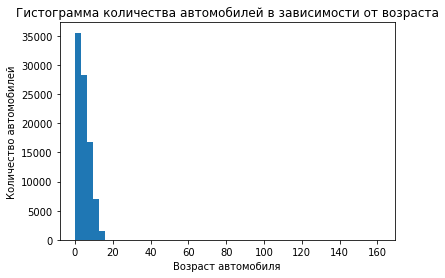

In [62]:
plt.hist(df['vehicle_age'], bins=50)
plt.title('Гистограмма количества автомобилей в зависимости от возраста')
plt.xlabel('Возраст автомобиля')
plt.ylabel('Количество автомобилей')
plt.show()

Большая часть автомобилей имеет возраст до 20 лет, ограничем этим значением нашу выборку.

In [63]:
df = df.query('vehicle_age <= 20').reset_index(drop=True)

In [64]:
df.describe()

,at_fault,vehicle_age,intersection,cellphone_in_use
count,89147.000000,89147.000000,89147.000000,89147.000000
mean,0.525379,4.885145,0.224203,0.021111
std,0.499358,3.114534,0.417059,0.143756
min,0.000000,0.000000,0.000000,0.000000
25%,0.000000,3.000000,0.000000,0.000000
50%,1.000000,4.000000,0.000000,0.000000
75%,1.000000,7.000000,0.000000,0.000000
max,1.000000,19.000000,1.000000,1.000000


In [65]:
df['vehicle_age'].astype('int').dtypes

dtype('int64')

In [66]:
df['cellphone_in_use'].astype('int').dtypes

dtype('int64')

In [67]:
df['intersection'].astype('int').dtypes

dtype('int64')

**Вывод** 

Четыре автомобиля отсеялось данные готовы к построению моделей.

###  Подготовка данных к построению моделей

###  Разделение данных на тренировочную, тестовую и валидационную выборки

In [68]:
features = df.drop(['at_fault'], axis=1)
target = df['at_fault']

Разделим данные на три выборки: тренировочную, валидационную и тестовую в соотношении 60% - 20% - 20%.

In [69]:
features_train, features_valid, target_train, target_valid = train_test_split(
    features, target, test_size=0.40, random_state=12345)
# Отделяем обучающую выборку
features_test, features_valid, target_test, target_valid = train_test_split(
    features_valid, target_valid, test_size=0.50, random_state=12345)

In [70]:
print('Размер тренировочной выборки', features_train.shape)
print('Размер валидационной выборки', features_valid.shape)
print('Размер тестовой выборки', features_test.shape)

Размер тренировочной выборки (53488, 9)
Размер валидационной выборки (17830, 9)
Размер тестовой выборки (17829, 9)


**Вывод**

Данные разделены на выборки для последующего обучения моделей.

###  Кодирование признаков

Выделим численные и категорильные признаки.
Признаки 'intersection' и 'cellphone_in_use' по факту тоже категорильные, но они уже принимают значение 0 либо 1, по этому не будем их кодировать. 

In [71]:
numeric = ['vehicle_age']
category = ['party_sobriety', 'road_surface', 'lighting', 'road_condition_1', 'control_device', 'weather_1']
uncoded = ['intersection', 'cellphone_in_use']

In [72]:
features_train_numeric = features_train[numeric].reset_index(drop=True)
features_valid_numeric = features_valid[numeric].reset_index(drop=True)
features_test_numeric = features_test[numeric].reset_index(drop=True)

features_train_category = features_train[category].reset_index(drop=True)
features_valid_category = features_valid[category].reset_index(drop=True)
features_test_category = features_test[category]

features_train_uncoded = features_train[uncoded].reset_index(drop=True) 
features_valid_uncoded = features_valid[uncoded].reset_index(drop=True)
features_test_uncoded = features_test[uncoded].reset_index(drop=True)


Сначала закодируем категорильные признаки с помощью OneHotEncoder.

In [73]:
ohe = OneHotEncoder(handle_unknown='ignore',sparse=False)


feature_arr = ohe.fit_transform(features_train_category)
feature_labels = ohe.get_feature_names(features_train_category.columns)
features_train_ohe = pd.DataFrame(feature_arr, columns=feature_labels)

feature_arr_1 = ohe.fit_transform(features_valid_category)
feature_labels_1 = ohe.get_feature_names(features_valid_category.columns)
features_valid_ohe = pd.DataFrame(feature_arr_1, columns=feature_labels_1)

feature_arr_2 = ohe.fit_transform(features_test_category)
feature_labels_2 = ohe.get_feature_names(features_test_category.columns)
features_test_ohe = pd.DataFrame(feature_arr_2, columns=feature_labels_2)

In [74]:
features_train_ohe.head(5)

,"party_sobriety_had been drinking, impairment unknown","party_sobriety_had been drinking, not under influence","party_sobriety_had been drinking, under influence",party_sobriety_had not been drinking,party_sobriety_impairment unknown,party_sobriety_not applicable,road_surface_dry,road_surface_slippery,road_surface_snowy,road_surface_wet,...,control_device_none,control_device_not functioning,control_device_obscured,weather_1_clear,weather_1_cloudy,weather_1_fog,weather_1_other,weather_1_raining,weather_1_snowing,weather_1_wind
0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,...,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
4,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,...,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0


Теперь проведём масштабирование численных признаков.

In [75]:
scaler = StandardScaler()
scaler.fit(features_train_numeric)

features_scaled = scaler.transform(features_train_numeric)
features_train_scaled = pd.DataFrame(features_scaled, columns=features_train_numeric.columns)

features_scaled_1 = scaler.transform(features_valid_numeric)
features_valid_scaled = pd.DataFrame(features_scaled_1, columns=features_valid_numeric.columns)

features_scaled_2 = scaler.transform(features_test_numeric)
features_test_scaled = pd.DataFrame(features_scaled_2, columns=features_test_numeric.columns)

In [76]:
features_train_scaled.head(5)
features_train_uncoded.shape

(53488, 2)

In [77]:
features_train_coded = pd.concat([features_train_ohe, features_train_scaled, features_train_uncoded], axis=1)
features_valid_coded = pd.concat([features_valid_ohe, features_valid_scaled, features_valid_uncoded], axis=1)
features_test_coded = pd.concat([features_test_ohe, features_test_scaled, features_test_uncoded], axis=1)

In [78]:
features_train_coded.head(5)

,"party_sobriety_had been drinking, impairment unknown","party_sobriety_had been drinking, not under influence","party_sobriety_had been drinking, under influence",party_sobriety_had not been drinking,party_sobriety_impairment unknown,party_sobriety_not applicable,road_surface_dry,road_surface_slippery,road_surface_snowy,road_surface_wet,...,weather_1_clear,weather_1_cloudy,weather_1_fog,weather_1_other,weather_1_raining,weather_1_snowing,weather_1_wind,vehicle_age,intersection,cellphone_in_use
0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,-1.566958,1.0,0.0
1,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.605644,0.0,0.0
2,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.605644,1.0,0.0
3,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,-0.605644,0.0,0.0
4,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.316985,0.0,0.0


In [79]:
features_train_coded.shape

(53488, 37)

In [80]:
features_valid_coded.shape

(17830, 37)

In [81]:
features_test_coded.shape

(17829, 37)

**Вывод**

Получены тренировочная, валидационная и тестовая выборки.

###  Обучение моделей

В качестве метрики будем использовать F1 метрику, т.к. она даёт оптимальный баланс точности и полноты.

####  Модель решающего дерева

In [82]:
dt_params = {
    'max_depth': range (1,13),
    
}

model_DecisionTree = GridSearchCV(DecisionTreeClassifier(random_state=12345), dt_params, scoring = 'f1')
model_Dt = model_DecisionTree.fit(features_train_coded, target_train)
print('Оптимальные параметры: ',model_Dt.best_params_)

Оптимальные параметры:  {'max_depth': 5}


In [83]:
predictions_DT_valid = model_Dt.predict(features_valid_coded)
f1_Decision_Tree_valid = f1_score(target_valid, predictions_DT_valid)

In [84]:
print(f'Максимальное значение f1 на валидационной выборке: {f1_Decision_Tree_valid}')

Максимальное значение f1 на валидационной выборке: 0.6088533011028856


**Вывод** 

Лучшее значение F1 (0.6088) получилась при параметре max_depth = 5.  

####  Модель случайного леса

In [85]:
rf_params = {
    'n_estimators': range(1, 121,10),
    'max_depth': range (1, 11)
}

model_RandomForest = GridSearchCV(RandomForestClassifier(random_state=12345), rf_params, scoring = 'f1')
model_RF = model_RandomForest.fit(features_train_coded, target_train)
print('Оптимальные параметры: ', model_RF.best_params_)

Оптимальные параметры:  {'max_depth': 1, 'n_estimators': 11}


In [86]:
predictions_RF_valid = model_RF.predict(features_valid_coded)
f1_Random_Forest_valid = f1_score(target_valid, predictions_RF_valid)
print(f'Максимальное значение f1 на валидационной выборке: {f1_Random_Forest_valid}')

Максимальное значение f1 на валидационной выборке: 0.6847637664588943


**Вывод** 

Лучшее значение F1 (0.6847) получилась при параметре max_depth = 1, n_estimators = 11.

####  Модель градиендный бустинг CatBoost

In [87]:
features_train.head(5)

,party_sobriety,road_surface,lighting,road_condition_1,vehicle_age,intersection,cellphone_in_use,control_device,weather_1
29417,had not been drinking,dry,dark with street lights,normal,0.0,1.0,0.0,functioning,clear
73539,"had been drinking, under influence",dry,daylight,normal,3.0,0.0,0.0,none,clear
13368,had not been drinking,dry,dark with street lights,normal,3.0,1.0,0.0,none,clear
57665,had not been drinking,wet,daylight,normal,3.0,0.0,0.0,none,raining
17162,had not been drinking,dry,daylight,normal,9.0,0.0,0.0,none,clear


In [88]:
cat_features = ['party_sobriety', 'road_surface', 'lighting',
                'road_condition_1', 'control_device', 'weather_1']

cb = CatBoostClassifier(loss_function="Logloss", iterations=70, eval_metric = 'F1')
cb_f1 = cb.fit(features_train, target_train, cat_features=cat_features, verbose=10)

Learning rate set to 0.5
0:	learn: 0.3103088	total: 103ms	remaining: 7.11s
10:	learn: 0.4882912	total: 323ms	remaining: 1.73s
20:	learn: 0.5272301	total: 590ms	remaining: 1.38s
30:	learn: 0.5530636	total: 830ms	remaining: 1.04s
40:	learn: 0.5540627	total: 1.08s	remaining: 764ms
50:	learn: 0.5521776	total: 1.33s	remaining: 496ms
60:	learn: 0.5535784	total: 1.58s	remaining: 233ms
69:	learn: 0.5317921	total: 1.8s	remaining: 0us


In [89]:
predicted_cat_valid = cb_f1.predict(features_valid)
f1_Cat_valid = cb_f1.score(predicted_cat_valid, target_valid)
print(f'F1 на валидационной выборке: {f1_Cat_valid}')

F1 на валидационной выборке: 0.5206393718452047


**Вывод** 

Для модели CatBoost F1 на валидационной выборке: 0.5206

###  Выбор модели

Для выбора модели составим таблицу с результатами показателя F1 на валидационной  выборке.

In [90]:
predictive_model_scores = pd.DataFrame(data=[('Decision Tree',f1_Decision_Tree_valid), 
                                             ('Random Forest',f1_Random_Forest_valid),
                                            ('CatBoost',f1_Cat_valid)], 
                                       columns=['model', 'valid_f1'])
predictive_model_scores

,model,valid_f1
0,Decision Tree,0.608853
1,Random Forest,0.684764
2,CatBoost,0.520639


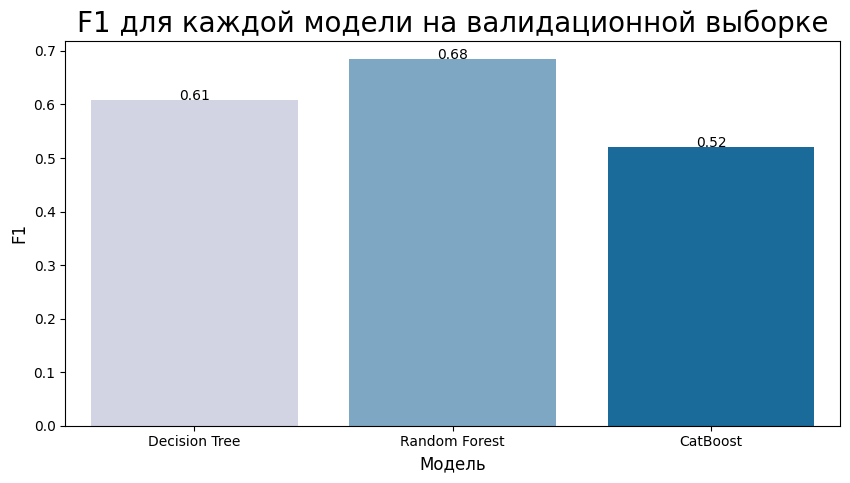

In [91]:
plt.style.use('default')
plt.figure(figsize=(10,5))
p=sns.barplot(x='model', y='valid_f1', data=predictive_model_scores, palette='PuBu')
plt.title('F1 для каждой модели на валидационной выборке', fontsize = 20)
plt.xlabel('Модель', fontsize = 12)
plt.ylabel('F1', fontsize = 12)
for index, row in predictive_model_scores.iterrows():
    p.text(x=row.name, y=row.valid_f1, s=round(row.valid_f1,2), color='black', horizontalalignment='center');

### Тестирование модели

Случайный лес

In [92]:
model_Random_Forest = RandomForestClassifier(random_state=12345, n_estimators=111, max_depth=3)
model_Random_Forest.fit(features_train_coded, target_train)
predictions_valid = model_Random_Forest.predict(features_valid_coded)
predictions_RF_test = model_Random_Forest.predict(features_test_coded)
f1_Random_Forest_valid = f1_score(target_valid, predictions_valid) 
f1_Random_Forest_test = f1_score(target_test, predictions_RF_test)
print('F1 для случайного леса на валидационной выборке', f1_Random_Forest_valid)
print('F1 для случайного леса на тестовой выборке',f1_Random_Forest_test)


F1 для случайного леса на валидационной выборке 0.6363924767731702
F1 для случайного леса на тестовой выборке 0.6386904223568779


**Вывод**

Лучший результат показала модель случайного леса, на тестовой выборке параметр F1 = 0.64

###  Матрица ошибок

Создадим матрицу ошибок выбранной модели.

In [93]:
cm_RF = confusion_matrix(target_test, predictions_RF_test)

In [94]:
cm_df_rf = pd.DataFrame(cm_RF, index=['Actually Not At Fault', 'Actually At Fault'],
                 columns=['Predicted Not At Fault', 'Predicted At Fault'])

####  Матрица ошибок случайного леса

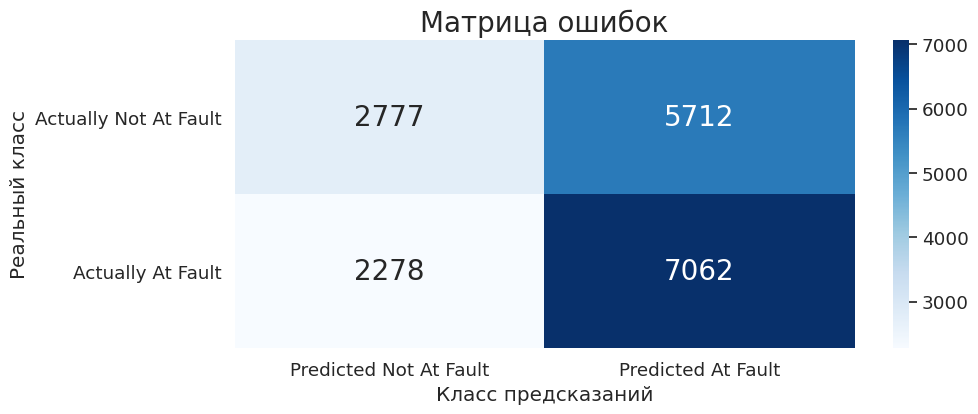

In [95]:
sns.set(font_scale=1.2)
plt.figure(figsize=(10,4))
    
sns.heatmap(cm_RF, annot=True, fmt='g', cmap="Blues",xticklabels=cm_df_rf.columns, yticklabels=cm_df_rf.index, annot_kws={"size": 20})
plt.title("Матрица ошибок", size=20)
plt.xlabel('Класс предсказаний')
plt.ylabel('Реальный класс');

In [96]:
TP = cm_RF[0][0]
TN = cm_RF[1][1]
FP = cm_RF[0][1]
FN = cm_RF[1][0]
total = cm_RF[0][0]+cm_RF[1][1]+cm_RF[0][1]+cm_RF[1][0]

print('Всего предсказаний:',total)
print(f'Правильно классифицированные: {np.round((TP+TN)/total*100)}%')
print(f'Правильно классифицированная вина: {np.round(TP/(TP+FN)*100)}%')
print(f'Правильно классифицированое отсутствие вины: {np.round(TN/(TN+FP)*100)}%')
print(f'Прогнозируемая вина, соответствующая действительности: {np.round(TP/(TP+FP)*100)}%')
print(f'Прогнозируемое отсутствие вины, которой так же на самом деле нет: {np.round(TN/(TN+FN)*100)}%')

Всего предсказаний: 17829
Правильно классифицированные: 55.0%
Правильно классифицированная вина: 55.0%
Правильно классифицированое отсутствие вины: 55.0%
Прогнозируемая вина, соответствующая действительности: 33.0%
Прогнозируемое отсутствие вины, которой так же на самом деле нет: 76.0%


## Проведите анализ важности факторов ДТП

Лучший результат показала модель случайного леса, для неё и проведём анализ важности вакторов ДТП.

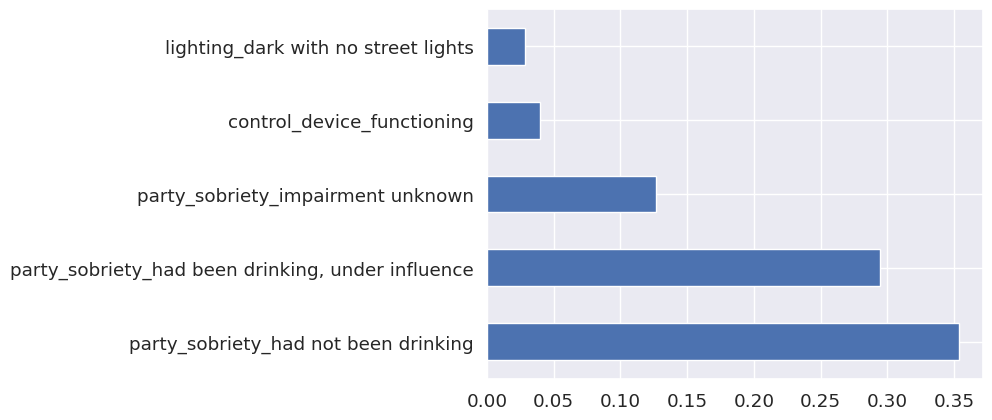

In [97]:
feat_importances_dt = pd.Series((model_Random_Forest.feature_importances_), index=features_train_coded.columns)
feat_importances_dt.nlargest(5).plot(kind='barh')
plt.show()

Данная модель больше всего обращает внимание на трезвость участника, а именно на показатель: "не пил"

Построим диаграмму, в которой отразим зависимость числа ДТП от уровня трезвости.

In [98]:
query = '''
SELECT distinct party_sobriety,
       count(case_id) count_party_sobriety
FROM parties
WHERE party_sobriety != 'had not been drinking'
   and party_sobriety != 'not applicable'
GROUP BY party_sobriety
ORDER BY count_party_sobriety desc
'''
party_sobriety = pd.read_sql_query(query, con=engine)
party_sobriety

,party_sobriety,count_party_sobriety
0,impairment unknown,232901
1,"had been drinking, under influence",112413
2,"had been drinking, impairment unknown",21419
3,"had been drinking, not under influence",17650


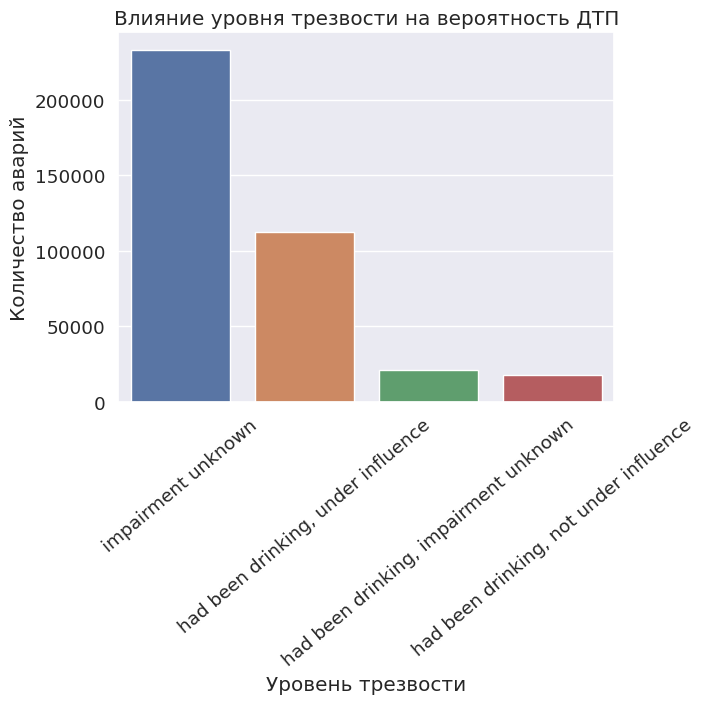

In [99]:
sns.barplot(data = party_sobriety, x='party_sobriety', y='count_party_sobriety')
plt.title('Влияние уровня трезвости на вероятность ДТП')
plt.xticks(rotation=40)
plt.xlabel('Уровень трезвости')
plt.ylabel('Количество аварий')
plt.show()

## Выводы

**Исходя из полученных данных, можно сделать вывод, что наилучшей моделью является модель "Случайного леса":**

- F1 на тестовой выбрке = 0.64
- Всего предсказаний: 17829
- Правильно классифицированные: 55.0%
- Правильно классифицированная вина: 55.0%
- Правильно классифицированое отсутствие вины: 55.0%
- Прогнозируемая вина, соответствующая действительности: 33.0%
- Прогнозируемое отсутствие вины, которой так же на самом деле нет: 76.0%
- Данная модель больше всего обращает внимание на трезвость участника, а именно на показатель: "Не пил".

**Так как самый важный фактор ДТП — уровень трезвости виновника (party_sobriety), то можно:**

- оборудовать автомобиль алкоключем
- добавить камеру, направленную на водительское место